In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [103]:
class Value():
    def __init__(self,data,operation=None,_children =(),label=None):
        self.data = data
        self.grad = 0.0
        self.label = label if label is not None else str(data)
        self.operation = operation
        self._backprop = lambda: None
        self.children = set(_children)
        
    def __repr__(self):
        return f"Value:{self.data},label:{self.label}"
        
    def __add__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data+other.data,"+",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += 1.0*v.grad
            other.grad += 1.0*v.grad
            
        v._backprop = backprop
        return v
        
    def __mul__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data*other.data,"*",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += other.data*v.grad
            other.grad += self.data*v.grad
            
        v._backprop = backprop
        return v

    def __pow__(self,other):
        assert isinstance(other,(int,float)),"Only int or float"
        v = Value(self.data**other,"pow",(self,))
        def backprop():
            self.grad += other.data*(self.data**(other.data - 1)) * v.grad
        v._backprop = backprop
        return v
    def __rmul__(self,other):  
        return self*other

    def __radd__(self,other):
        return self+other
        
    def __truediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return self * (other.data**-1)
        
    def __rtruediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return ((self.data)**-1) * other 
        
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) +1)
        v = Value(tanh,"tanh",(self,))
        
        def backprop():
            self.grad += (1 - (tanh**2)) * v.grad
        
        v._backprop = backprop
        return v
            
    def backprop(self):
        def topological_sort(root,sorted_graph):            
            
            # for x in root.children:
            #     if x not in sorted_graph:
            #         sorted_graph.append(x)
            
            if root not in sorted_graph:
                for x in root.children:
                    topological_sort(x,sorted_graph)
                
                
                sorted_graph.append(root)
            return sorted_graph
        
        topo_list = topological_sort(self,[])
        self.grad = 1
        for x in topo_list[::-1]:
            x._backprop()

In [104]:
a = Value(1.0,label="a")
a1 = Value(1.5,label="a1")
b = Value(1.75,label="b")
c = b * a1;c.label = "c";
d = Value(1.25,label="d")
e = a * b;e.label = "e";
f = c + e;f.label = "f";
g = d * f;g.label = "g";
o = g.tanh();o.label = "l"

In [105]:
import graphviz as graph 

In [106]:
def draw_nn(root: Value,dot):
    dot.node(root.label,label = "{ %s | data %.4f | grad %.4f }" % (root.label, root.data, root.grad), shape='record')
    
    if root.operation != None:
        dot.node(root.operation+root.label,label =root.operation)
        dot.edge(root.operation+root.label,root.label)
    if root.children != None:
        for x in root.children:
            dot.node(x.label)
            dot.edge(x.label,root.operation+root.label)
            draw_nn(x,dot)
    return dot
    

In [107]:
o.backprop()

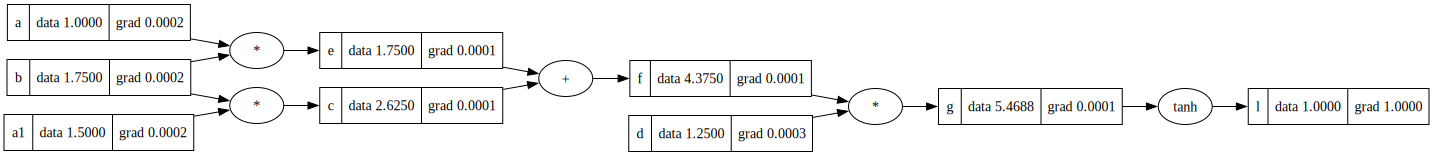

In [108]:
dot = graph.Digraph("nn",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(o,dot)

In [ ]:
class Neuron:
    def __init__(self,nin):
        self.W = [Value(x) for x in np.random.normal(size=nin)]
        self.b = Value(np.random.normal(size=1)[0],label="bias")

    def __call__(self,X):
        out = sum((w*x for w,x in zip(self.W,X)),self.b)
        out = out.tanh()
        return out

    def parameters(self):
        return self.W + [self.b]

class Layer:
    def __init__(self,nin,n,layer = 1):
        self.neurons = [Neuron(nin) for x in range(n)]
        self.layer = layer
        
    def __call__(self,X):
        layer_out = []
        for i,n in enumerate(self.neurons):
            out = n(X)
            out.label = f"N{self.layer}{i}"
            layer_out.append(out)        

        return layer_out[0] if len(layer_out)==1 else layer_out
        
    def parameters(self):
        layer_parameters = []
        for n in self.neurons:
            layer_parameters.append(n.parameters())
        return layer_parameters

class NeuralNet:
    def __init__(self,nin,layer_spec : list):
        self.nin = nin
        self.nlayers = layer_spec
        self.layerspec = [nin] + layer_spec
        self.layers=[Layer(self.layerspec[x],self.layerspec[x+1],layer=x+1) for x in range(len(self.layerspec)-1)]
    def __call__(self,X):
        for layer in self.layers:
            X = layer(X)
        return X       

In [112]:
X = [1.1,2,3]
l = Layer(3,1)

In [113]:
out = l(X)

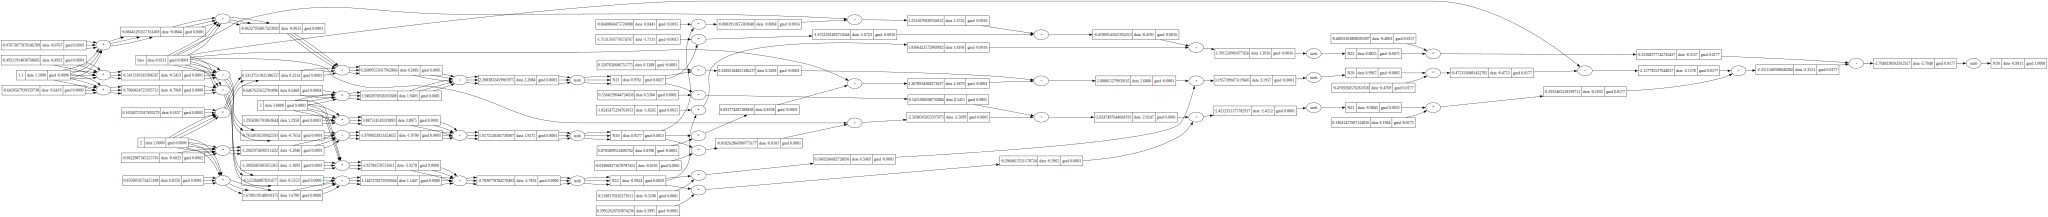

In [120]:
dot = graph.Digraph("nn",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(out,dot)

In [115]:
out

Value:-0.6188168803779701,label:N10

In [116]:
l.parameters()

[[Value:0.4555868507357123,label:0.4555868507357123,
  Value:-0.8784488043157129,label:-0.8784488043157129,
  Value:0.28553331685776534,label:0.28553331685776534,
  Value:-0.32393335378472793,label:bias]]

In [117]:
nn = NeuralNet(3,[3,3,1])

In [118]:
out = nn(X)

In [119]:
out.backprop()